In [1]:
# Please do not edit this cell.
# Imports
import os, random, time, math, json
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import imageio

In [2]:
# URLs
ZIP_URL = "https://sds365.s3.amazonaws.com/lfw/lfw-deepfunneled.zip"
ATTR_URL = "https://sds365.s3.amazonaws.com/lfw/lfw_attributes.txt"

import requests
import os
import zipfile
import shutil
from pathlib import Path
import urllib.request

# Paths
BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / "data"
ZIP_PATH = DATA_DIR / "lfw-deepfunneled.zip"
ATTR_PATH = DATA_DIR / "lfw_attributes.txt"
UNZIP_DIR = DATA_DIR 

def download(url, dest):
    if dest.exists():
        print(f"{dest.name} already exists, skipping download.")
        return
    print(f"Downloading {url} -> {dest}")
    urllib.request.urlretrieve(url, dest)

def unzip(zip_path, extract_to):
    if (extract_to / "lfw_attributes").exists():
        print(f"{extract_to} already exists, skipping unzip.")
        return
    print(f"Unzipping {zip_path} -> {extract_to}")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_to)

DATA_DIR.mkdir(parents=True, exist_ok=True)

download(ZIP_URL, ZIP_PATH)
download(ATTR_URL, ATTR_PATH)
unzip(ZIP_PATH, UNZIP_DIR)

print("Done.")

lfw-deepfunneled.zip already exists, skipping download.
lfw_attributes.txt already exists, skipping download.
Unzipping /pscratch/sd/j/jywu/learn-torch/Smiles/data/lfw-deepfunneled.zip -> /pscratch/sd/j/jywu/learn-torch/Smiles/data


Done.


In [3]:
DATASET_PATH ="/pscratch/sd/j/jywu/learn-torch/Smiles/data/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/pscratch/sd/j/jywu/learn-torch/Smiles/data/lfw_attributes.txt"

dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})

dataset = pd.DataFrame(dataset)
dataset = dataset.groupby("person").filter(lambda x: len(x) < 100 )
dataset.head(10)

,person,path
0,Wolfgang_Schuessel,/pscratch/sd/j/jywu/learn-torch/Smiles/data/lf...
1,Wolfgang_Schuessel,/pscratch/sd/j/jywu/learn-torch/Smiles/data/lf...
2,Wolfgang_Schuessel,/pscratch/sd/j/jywu/learn-torch/Smiles/data/lf...
3,Wolfgang_Schuessel,/pscratch/sd/j/jywu/learn-torch/Smiles/data/lf...
4,Michael_Sheehan,/pscratch/sd/j/jywu/learn-torch/Smiles/data/lf...
5,Albert_Montanes,/pscratch/sd/j/jywu/learn-torch/Smiles/data/lf...
6,John_Moxley,/pscratch/sd/j/jywu/learn-torch/Smiles/data/lf...
7,Marc_Anthony,/pscratch/sd/j/jywu/learn-torch/Smiles/data/lf...
8,Yolanda_King,/pscratch/sd/j/jywu/learn-torch/Smiles/data/lf...
9,John_Coomber,/pscratch/sd/j/jywu/learn-torch/Smiles/data/lf...


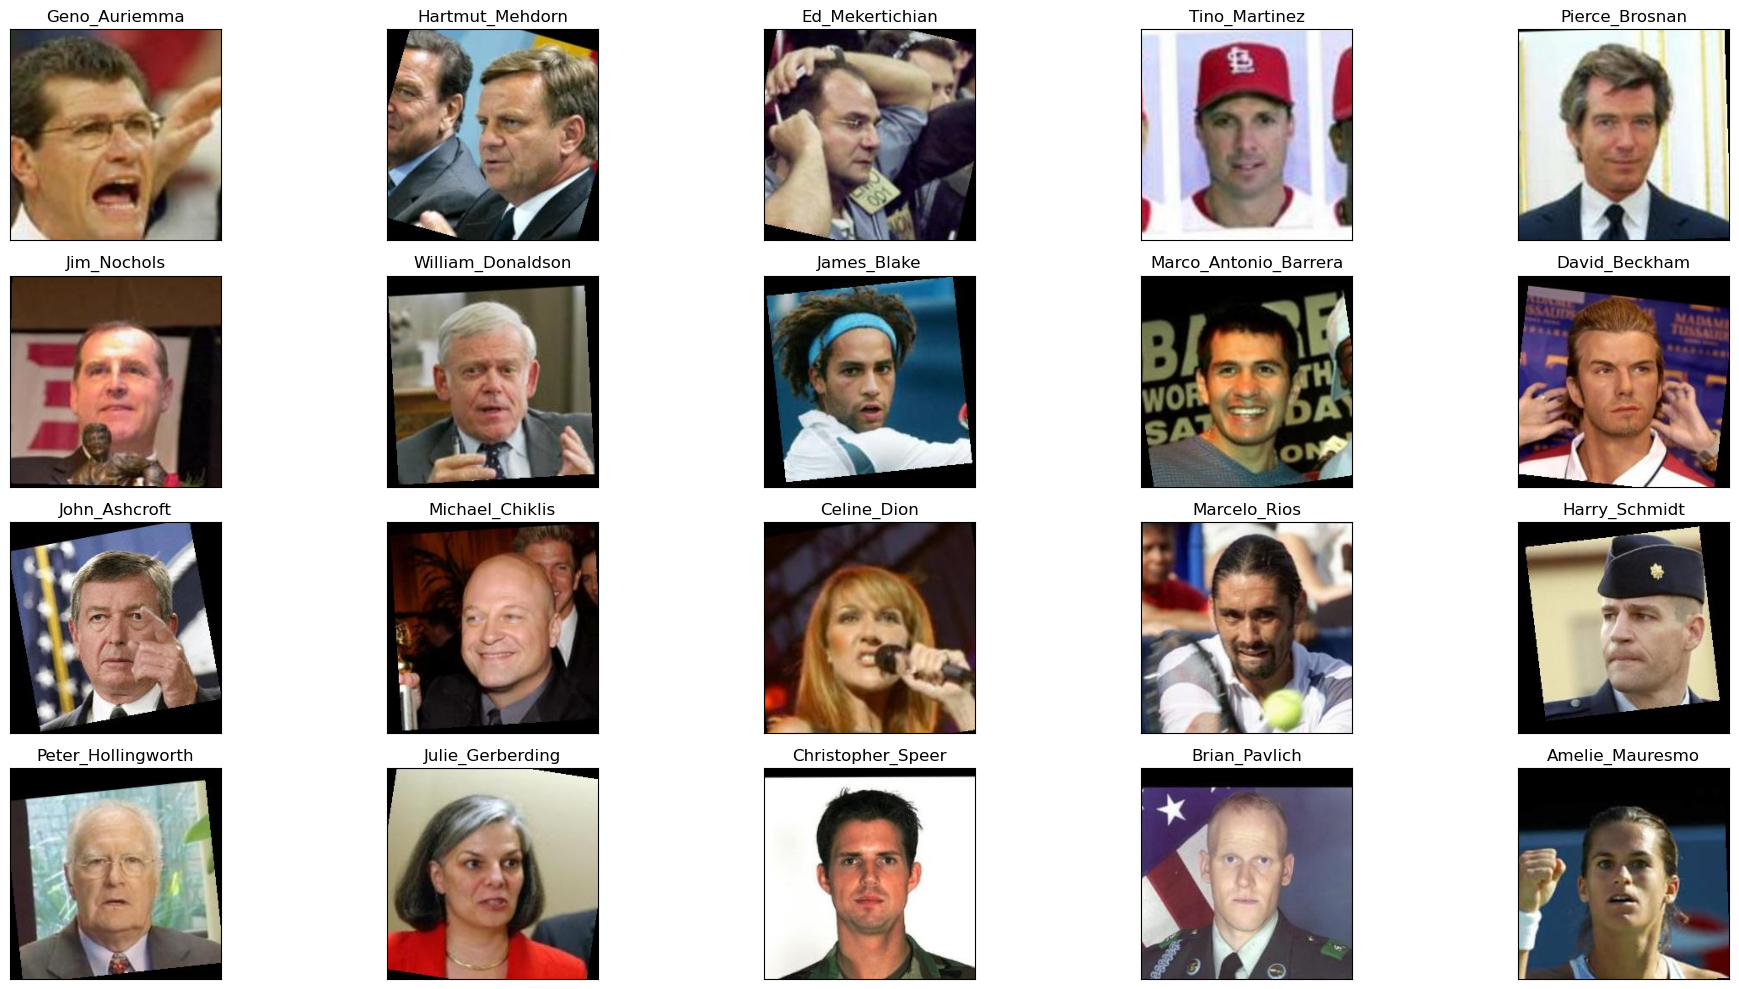

In [4]:
sampled_id = []

plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
    sampled_id.append(idx)
plt.tight_layout()
plt.show()

In [5]:
def fetch_dataset(dx=70, dy=70, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos,all_attrs

data, attrs = fetch_dataset()
data = np.array(data / 255, dtype='float32')

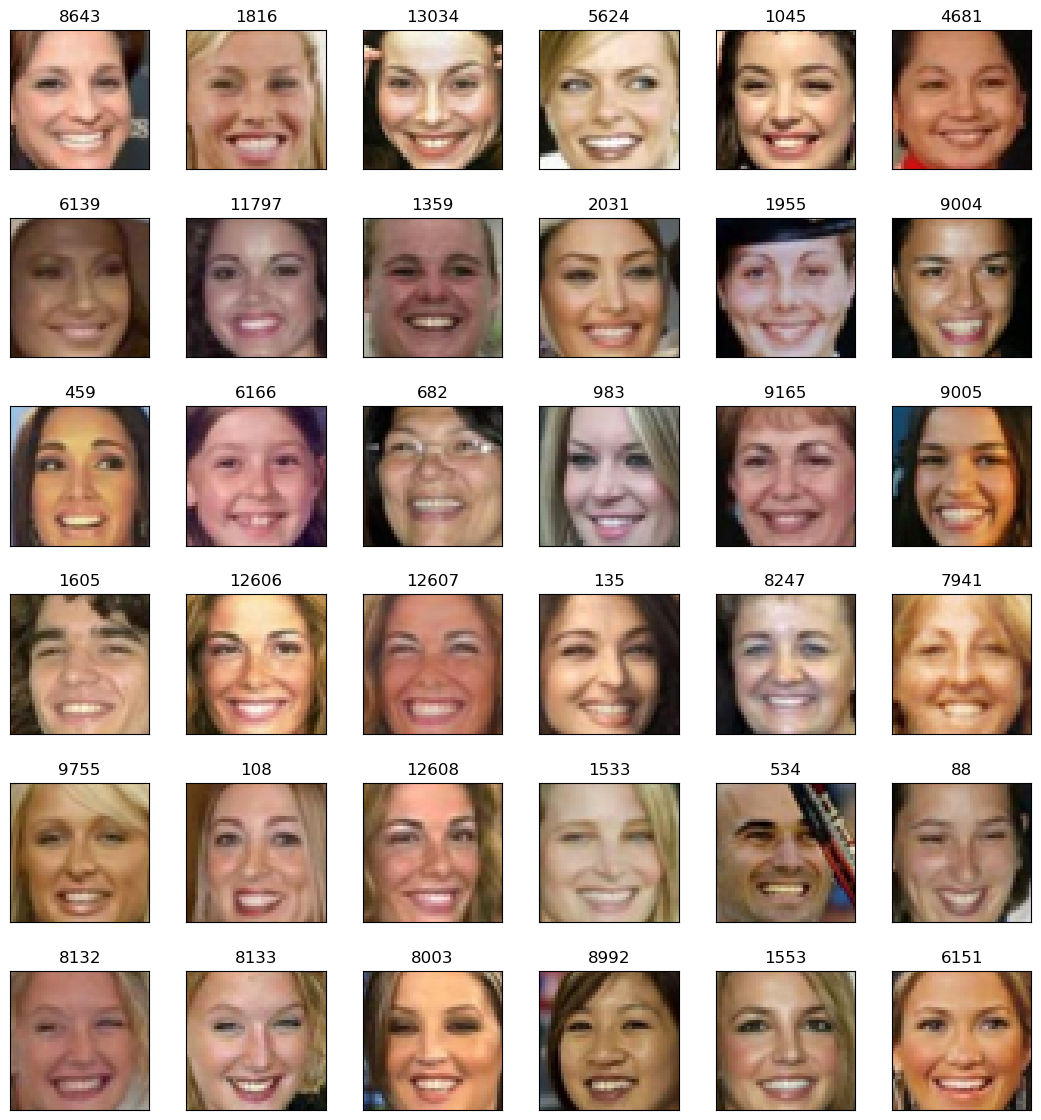

In [6]:
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.75 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
N_CHANNELS = 3

smile_ids = attrs['Smiling'].sort_values(ascending=False).head(36).index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(36).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(36).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(36).index.values
sunglasses_data = data[sunglasses_ids]

mustache_ids = attrs['Mustache'].sort_values(ascending=False).head(36).index.values
mustache_data = data[mustache_ids]

male_ids = attrs['Male'].sort_values(ascending=False).head(36).index.values
male_data = data[male_ids]

female_ids = attrs['Male'].sort_values(ascending=True).head(36).index.values
female_data = data[female_ids]

eyeclosed_ids = attrs['Eyes Open'].sort_values(ascending=True).head(36).index.values
eyeclosed_data = data[eyeclosed_ids]

mouthopen_ids = attrs['Mouth Wide Open'].sort_values(ascending=False).head(36).index.values
mouthopen_data = data[mouthopen_ids]

makeup_ids = attrs['Heavy Makeup'].sort_values(ascending=False).head(36).index.values
makeup_data = data[makeup_ids]

plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=smile_ids)

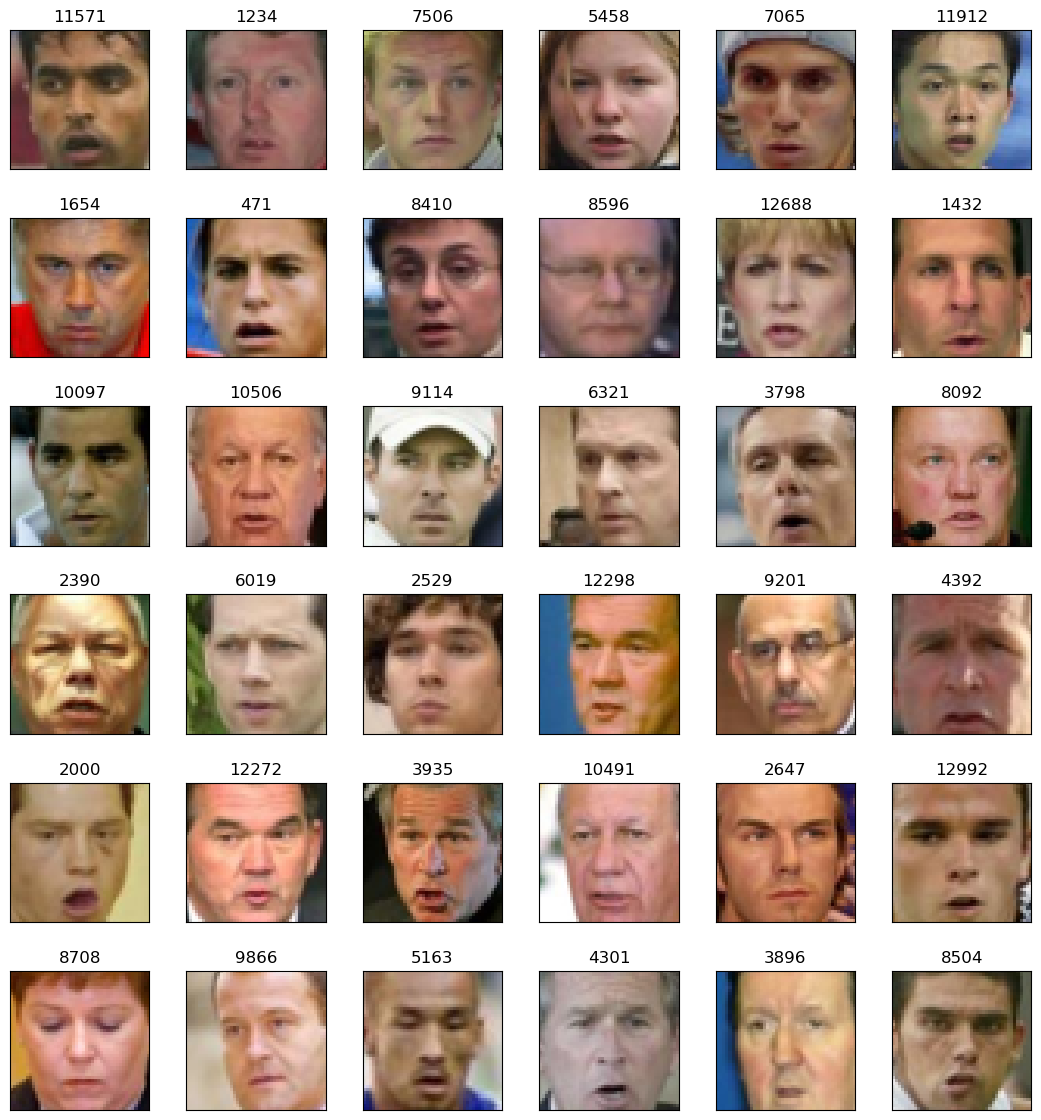

In [7]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=no_smile_ids)

In [8]:
# Start building the VAE model here


def reparameterize(mu, log_var):
    """
    mu: (batch, latent_dim)
    log_var: (batch, latent_dim)
    """
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + std * eps

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2)

        # Compute flattened size dynamically if desired
        # For input (3, 45, 45), it becomes 32 × 3 × 3 = 288
        self.fc_mu = nn.Linear(288, latent_dim)
        self.fc_log_var = nn.Linear(288, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1)

        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)

        z = reparameterize(mu, log_var)
        return z, mu, log_var
    
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        # Match TensorFlow reshape: (batch, 100) → (batch, 100, 1, 1)
        self.fc = nn.Linear(latent_dim, 100)

        self.deconv1 = nn.ConvTranspose2d(100, 64, kernel_size=3)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3)
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=5)
        self.deconv4 = nn.ConvTranspose2d(16, 3, kernel_size=6)

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 100, 1, 1)

        x = F.relu(self.deconv1(x))
        x = self.upsample(x)

        x = F.relu(self.deconv2(x))
        x = self.upsample(x)

        x = F.relu(self.deconv3(x))
        x = self.upsample(x)

        x = F.relu(self.deconv4(x))
        return x
    
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        recon = self.decoder(z)
        return recon, mu, log_var



In [9]:
def vae_loss_fn(y_true, y_pred, mu, logvar, factor, batch_size, latent_dim):
    # Reconstruction loss
    recon = (y_true - y_pred) ** 2
    recon = 0.5 * recon.sum() / batch_size * factor

    # KL divergence
    kl = (
        latent_dim
        + logvar
        - mu.pow(2)
        - logvar.exp()
    )
    kl = -0.5 * kl.sum() / batch_size

    return recon + kl

In [10]:
data_tensor = torch.tensor(data).permute(0, 3, 1, 2)  # Convert to (N, C, H, W)
dataset = TensorDataset(data_tensor)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LATENT_DIM = 100
FACTOR = 1.0
EPOCHS = 64
LR = 1e-3

model = VAE(LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for (x,) in train_loader:
        x = x.to(device)
        batch_size = x.size(0)

        optimizer.zero_grad()

        x_recon, mu, logvar = model(x)

        loss = vae_loss_fn(
            x, x_recon, mu, logvar, FACTOR, batch_size, LATENT_DIM
        )

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (x,) in test_loader:
            x = x.to(device)
            batch_size = x.size(0)

            x_recon, mu, logvar = model(x)
            loss = vae_loss_fn(
                x, x_recon, mu, logvar, FACTOR, batch_size, LATENT_DIM
            )
            test_loss += loss.item()

    test_loss /= len(test_loader)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Train Loss: {train_loss:.4f} "
        f"Test Loss: {test_loss:.4f}"
    )

Epoch [1/64] Train Loss: -4762.0689 Test Loss: -4866.3676
Epoch [2/64] Train Loss: -4872.0660 Test Loss: -4877.8013
Epoch [3/64] Train Loss: -4879.4863 Test Loss: -4882.8141
Epoch [4/64] Train Loss: -4883.9495 Test Loss: -4882.0513
Epoch [5/64] Train Loss: -4885.9863 Test Loss: -4886.8305
Epoch [6/64] Train Loss: -4887.4857 Test Loss: -4887.6659
Epoch [7/64] Train Loss: -4888.5903 Test Loss: -4887.0501
Epoch [8/64] Train Loss: -4889.4586 Test Loss: -4889.5148
Epoch [9/64] Train Loss: -4889.7013 Test Loss: -4888.2640
Epoch [10/64] Train Loss: -4890.1795 Test Loss: -4889.7305
Epoch [11/64] Train Loss: -4890.5944 Test Loss: -4890.4898
Epoch [12/64] Train Loss: -4890.9128 Test Loss: -4890.6829
Epoch [13/64] Train Loss: -4891.6324 Test Loss: -4890.1670
Epoch [14/64] Train Loss: -4892.0000 Test Loss: -4891.9004
Epoch [15/64] Train Loss: -4892.2895 Test Loss: -4892.1571
Epoch [16/64] Train Loss: -4892.7772 Test Loss: -4892.8607
Epoch [17/64] Train Loss: -4892.8983 Test Loss: -4892.7779
Epoch 

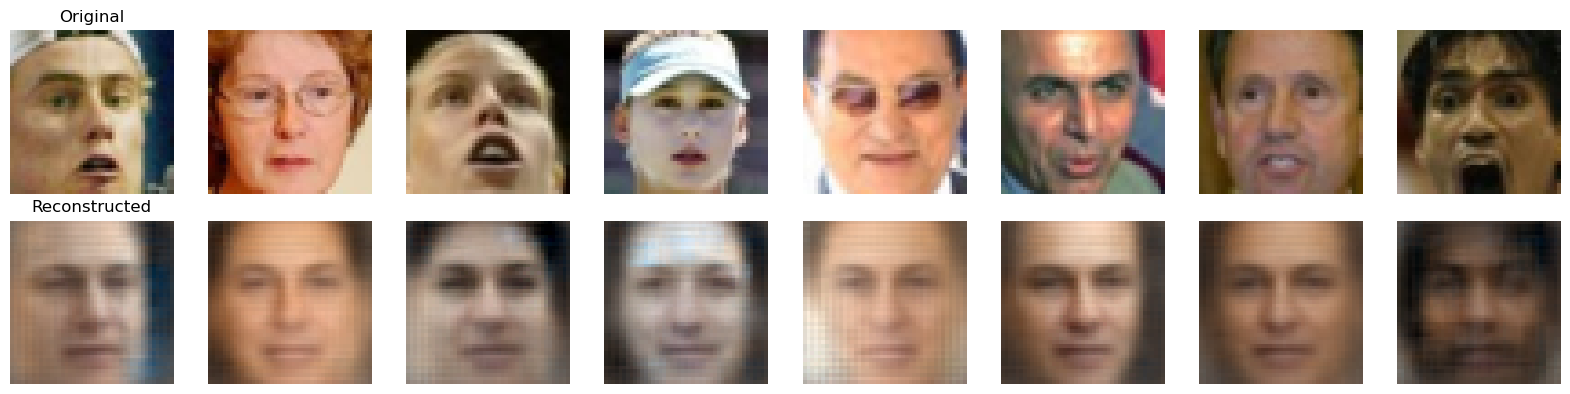

In [16]:
def compare_reconstructions(model, train_loader, device, num_images=8):
    model.eval()

    # Get one batch
    with torch.no_grad():
        for (x,) in train_loader:
            x = x.to(device)
            x_recon, _, _ = model(x)
            break  # only need one batch

    # Select first num_images
    x = x[:num_images]
    x_recon = x_recon[:num_images]

    # Move to CPU and convert to numpy
    x = x.cpu().numpy()
    x_recon = x_recon.cpu().numpy()

    # Convert from NCHW → NHWC
    x = np.transpose(x, (0, 2, 3, 1))
    x_recon = np.transpose(x_recon, (0, 2, 3, 1))

    # Plot
    fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))

    for i in range(num_images):
        # Original
        axes[0, i].imshow(x[i])
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Original")

        # Reconstructed
        axes[1, i].imshow(x_recon[i])
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()

compare_reconstructions(model, train_loader, device, num_images=8)


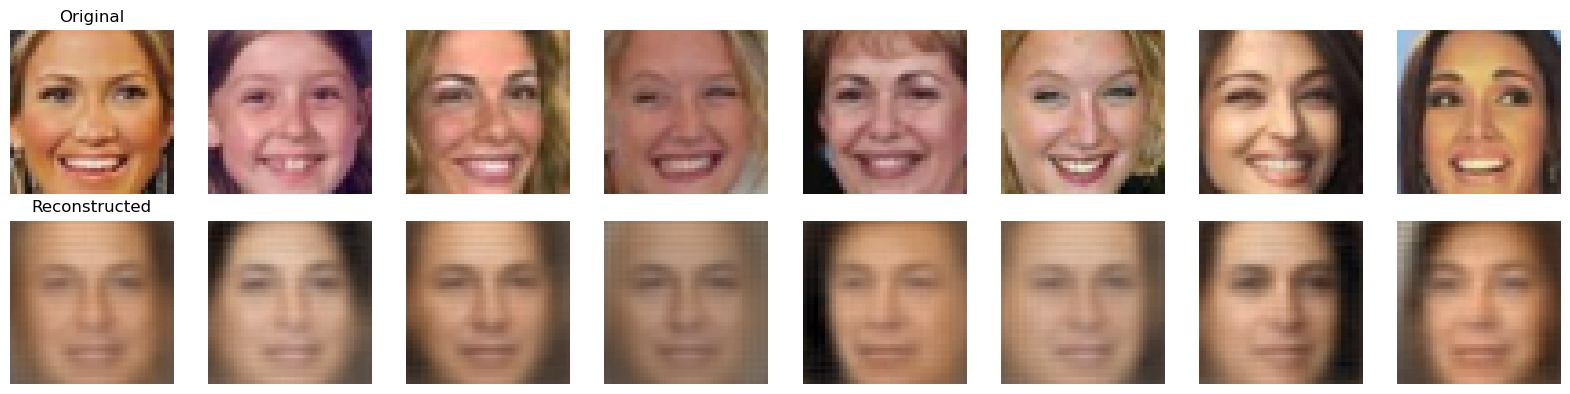

In [17]:
def compare_reconstructions_from_numpy(
    model,
    smile_data,
    device,
    num_images=8,
    seed=None
):
    """
    smile_data: numpy array of shape [N, W, H, C]
    """

    model.eval()

    if seed is not None:
        np.random.seed(seed)

    # Sample indices
    idx = np.random.choice(len(smile_data), num_images, replace=False)

    # Extract samples
    x = smile_data[idx]

    # Convert to torch tensor and NHWC → NCHW
    x = torch.from_numpy(x).float().permute(0, 3, 1, 2).to(device)

    with torch.no_grad():
        x_recon, _, _ = model(x)

    # Move back to CPU
    x = x.cpu().numpy()
    x_recon = x_recon.cpu().numpy()

    # NCHW → NHWC (restore [W, H, C])
    x = np.transpose(x, (0, 2, 3, 1))
    x_recon = np.transpose(x_recon, (0, 2, 3, 1))

    # Plot
    fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))

    for i in range(num_images):
        axes[0, i].imshow(x[i])
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Original")

        axes[1, i].imshow(x_recon[i])
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()

compare_reconstructions_from_numpy(
    model,
    smile_data,
    device,
    num_images=8,
    seed=42
)

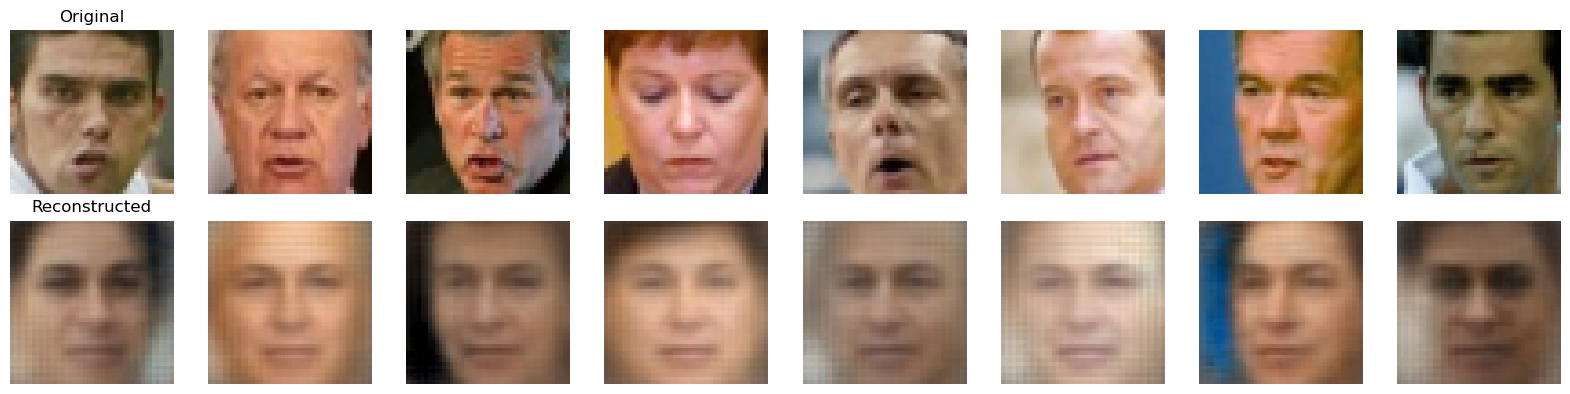

In [18]:
compare_reconstructions_from_numpy(
    model,
    no_smile_data,
    device,
    num_images=8,
    seed=42
)

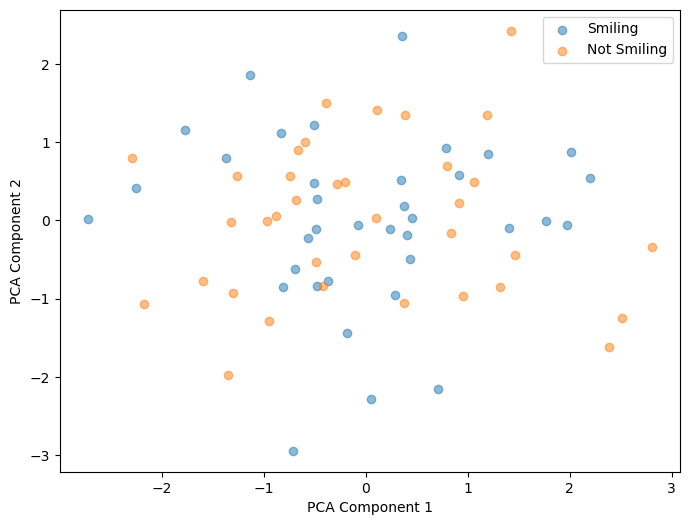

In [21]:
def extract_latent_from_numpy(model, data_np, device, batch_size=128):
    """
    data_np: numpy array [N, W, H, C]
    returns: numpy array [N, latent_dim]
    """
    model.eval()
    latents = []

    with torch.no_grad():
        for i in range(0, len(data_np), batch_size):
            batch = data_np[i:i+batch_size]

            # NHWC [W,H,C] → NCHW
            x = torch.from_numpy(batch).float().permute(0, 3, 2, 1).to(device)

            _, mu, _ = model(x)
            latents.append(mu.cpu().numpy())

    return np.concatenate(latents, axis=0)

from sklearn.decomposition import PCA

def latent_pca_2d(latent_vectors):
    """
    latent_vectors: numpy array of shape [N, latent_dim]
    returns: numpy array of shape [N, 2]
    """
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors)
    return latent_2d

def plot_latnet_points(data_np, model, device):
    data = torch.from_numpy(data_np).float().permute(0, 3, 1, 2).to(device)
    latent_vectors = extract_latent_from_numpy(model, data_np, device)
    latent_2d = latent_pca_2d(latent_vectors)

    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.5)


plt.figure(figsize=(8, 6))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plot_latnet_points(smile_data, model, device)
plot_latnet_points(no_smile_data, model, device)
plt.legend(["Smiling", "Not Smiling"])
plt.show()
